In [47]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample_poly
from scipy.signal import resample_poly, firwin, freqz, lfilter, cheby1, butter
# import matplotlib.pyplot as plt
from scipy import fftpack
import os
from random import randrange
from scipy import signal
from scipy.fftpack import fft, dct
from scipy import stats


In [48]:
path = os.path.dirname(os.getcwd()) + "/dataset/"
print(path)
sampling_rate = 4000

/home/vips/share/Vu/Snoring-Project/dataset/


# Preprocess data

In [64]:
framing(path, 4000, 128)
# randomly_cut_30s(path, "snoring101")

snoring101.wav (10245, 512)
none_snoring100.wav (80199, 512)
none_snoring101.wav (112693, 512)
snoring100.wav (59672, 512)


# Feature extraction for ML

## Stastistical feature

In [20]:
def nor(data):
    mi = np.min(data)*1.0
    ma = np.max(data)*1.0
    data = (2*data - ma - mi)/(ma - mi)
    return data

def stas_feature(data, spr):
    l = data.shape[0]  
    #fft
    yf = fft(data)
    yf = yf[:l//2]
    energy = 1/(l)*np.abs(yf)
    #feature
    r0 = 50*l//spr
    r1 = 250*l//spr
    r2 = 500*l//spr
    r3 = 800*l//spr
     
    mean = np.mean(energy)
    sd = np.std(energy)
    mean1 = np.mean(energy[r0:r1])/mean
    sd1 = np.std(energy[r0:r1])/sd
    mean2 = np.mean(energy[r1:r2])/mean
    sd2 = np.std(energy[r1:r2])/sd
    mean3 = np.mean(energy[r2:r3])/mean
    sd3 = np.std(energy[r2:r3])/sd
    return [mean1, mean2, mean3, sd1, sd2, sd3]

    

## MFCC features

In [34]:
def create_filter_banks(n_filters, spr, l):
    #create filter banks
    filter_banks = np.zeros([n_filters, l//2])
    lower_f = 50
    upper_f = spr//2
    band = np.linspace(2595*np.log(1 + lower_f/700), 2595*np.log(1 + upper_f/700), n_filters + 2)
    band = 700*(np.exp(band/2595) - 1)
    band = np.round(band*1000/(2*spr))
    for i in range(1, n_filters + 1):
        start = int(band[i - 1])
        end = int(band[i + 1])
        mid = int(band[i])
        filter_banks[i - 1][start:mid] = (1.0*np.arange(start, mid) - start)/(mid - start)
        filter_banks[i - 1][mid:end] = (end - 1.0*np.arange(mid, end))/(end - mid)
    return filter_banks

def MFCC(data, filter_banks):
    #fft
    sig = data
    l = sig.shape[0]
    yf = fft(sig)
    yf = yf[:l//2]
    energy = (1/l)*np.abs(yf)
    n_filters = filter_banks.shape[0]
    #filter
    coeff = []
    for i in range(0, n_filters):
        coeff.append(np.log(np.sum(filter_banks[i] * energy)))
    dct_coeff = dct(np.array(coeff))
    return dct_coeff[:n_filters//2]

filter_banks = create_filter_banks(26, sampling_rate, 512)

In [66]:
def feature_extract(data, spr):
    n, l = data.shape[:]
    feature_vectors = []
    hw = np.hamming(l)  
    for i in range(0, n):
        sig = data[i]
        #sig = nor(sig)
        # sig = sig - np.mean(sig)
        sig = sig * hw
        fea = mfcc(sig, spr, hop_length=1024,  n_mels=20)
        # fea = stas_feature(sig, spr)
        feature_vectors.append(fea)
    return feature_vectors 

[[ 2.24907879e+01  2.24260427e+01]
 [ 1.40169865e+01  1.47311315e+01]
 [ 9.25685895e+00  9.80551123e+00]
 [ 6.25658485e+00  6.36759667e+00]
 [-1.81389593e+01 -1.87004319e+01]
 [ 1.16060187e+00  5.63396285e-01]
 [ 6.61575572e-01  7.39541280e-01]
 [-1.04846295e-01  1.01119648e-02]
 [ 9.70552462e+00  1.03891406e+01]
 [-3.10654869e+00 -3.12026531e+00]
 [ 2.09398643e+00  1.76997289e+00]
 [-9.84065106e-01 -9.33759281e-01]
 [-4.77997414e+00 -4.85725405e+00]
 [-2.58594880e+00 -2.71649753e+00]
 [ 3.10229290e+00  2.85517532e+00]
 [ 3.38707452e+00  3.54865115e+00]
 [ 1.22548243e+00  1.51340805e+00]
 [-1.08179945e+00 -1.11637669e+00]
 [ 2.38107209e-03  1.15722262e-01]
 [-4.43097855e-01 -1.40355519e-01]]


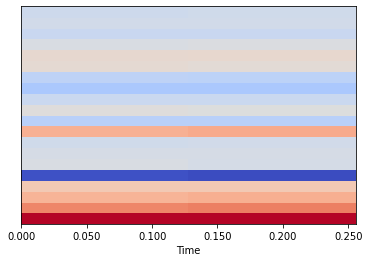

In [65]:
no_snoring = np.load(path + "snoring101.npy")

n, l = no_snoring.shape[:]
hw = np.hamming(l)
sig =  no_snoring[0]
sig = nor(sig)
sig = sig * hw

from librosa.feature import mfcc
import librosa.display
librosa_MFCC = mfcc(sig, sampling_rate, hop_length=512,  n_mels=20)
print(librosa_MFCC)
librosa.display.specshow(librosa_MFCC, sr=sampling_rate, x_axis='time')

# Machine Learning

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import os
import time
import pickle
import random

In [ ]:
def train(file_name):
    
    snoring_fea_vecs = np.load(path + "/feature/snoring_" + file_name + ".npy")
    no_snoring_fea_vecs = np.load(path + "/feature/non_snoring_" + file_name  + ".npy")
    n1 = snoring_fea_vecs.shape[0]
    n2 = no_snoring_fea_vecs.shape[0]
    n2 = int(n1)
    print(n1, n2)

    settings = "model" + file_name

    np.random.shuffle(snoring_fea_vecs)
    np.random.shuffle(no_snoring_fea_vecs)

    X = np.concatenate([snoring_fea_vecs, no_snoring_fea_vecs[:n2]], axis=0)
    Y = [0]*n1 + [1]*n2
    t1 = time.time()
    #SVM linear
    clf = svm.SVC(C = 100, kernel='rbf', gamma='scale')
    clf.fit(X,Y)
    pickle.dump(clf, open(path + "/model/" + settings + "/stats_model_SVM_linear.w",'wb')) 

    #train NB
    # clf = GaussianNB()
    # clf.fit(X, Y)
    # pickle.dump(clf, open(path + "/model/" + settings + "/model_NB.w",'wb'))

    #logistic
    # clf = LogisticRegression(random_state=0, solver='lbfgs')
    # clf.fit(X, Y)
    # pickle.dump(clf, open(path + "/model/" + settings + "/model_LR.w",'wb'))

    #tree
    # clf = DecisionTreeClassifier()
    # clf.fit(X, Y)
    # pickle.dump(clf, open(path + "/model/" + settings + "/model_DT.w",'wb'))

    #LDA
    # clf = LinearDiscriminantAnalysis()
    # clf.fit(X, Y)
    # pickle.dump(clf, open(path + "/model/" + settings + "/model_LDA.w",'wb'))

    #GMM
    # clf = GaussianMixture(n_components=2)
    # clf.fit(X)
    # pickle.dump(clf, open(path + "/model/" + settings + "/model_GMM.w",'wb'))

    t2 = time.time()
    print("training time:", t2-t1)

    t1 = time.time()
    r1 = np.sum(1-clf.predict(snoring_fea_vecs[:n1]))/(n1)
    if(r1 < 0.5):
        r1 = 1 - r1
    print("T", r1)
    n2 = no_snoring_fea_vecs.shape[0]
    r2 = np.sum(clf.predict(no_snoring_fea_vecs[:n2]))/(n2)
    if(r2 < 0.5):
        r2 = 1 - r2
    print("F", r2)
    t2 = time.time()
    print("testing time:", (t2-t1))

